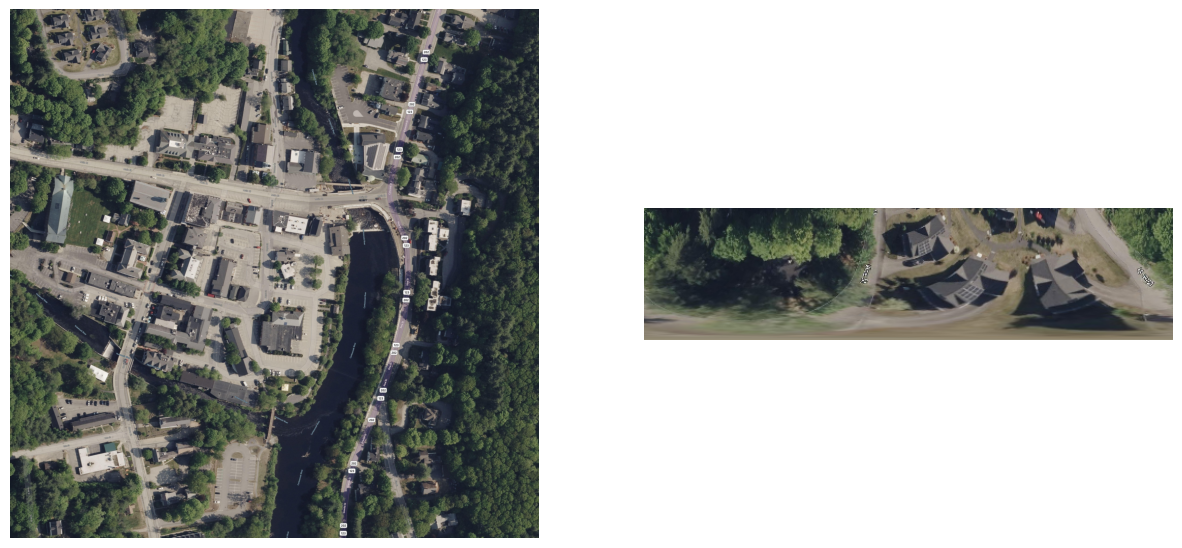

In [7]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import math

os.chdir("/tf/notebooks/")

def sample_within_bounds(signal, x, y, bounds):
    """
    Source: Where am I looking at? Joint Location and Orientation Estimation by Cross-View Matching CVPR2020
    Yujiao Shi, Xin Yu, Dylan Campbell, Hongdong Li.
    https://github.com/shiyujiao/cross_view_localization_DSM/blob/master/script/data_preparation.py
    """
    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    sample = np.zeros((x.shape[0], x.shape[1], signal.shape[-1]))
    sample[idxs, :] = signal[x[idxs], y[idxs], :]

    return sample

def sample_bilinear(signal, rx, ry):
    """
    Source: Where am I looking at? Joint Location and Orientation Estimation by Cross-View Matching CVPR2020
    Yujiao Shi, Xin Yu, Dylan Campbell, Hongdong Li.
    https://github.com/shiyujiao/cross_view_localization_DSM/blob/master/script/data_preparation.py
    """
    signal_dim_x = signal.shape[0]
    signal_dim_y = signal.shape[1]

    # obtain four sample coordinates
    ix0 = rx.astype(int)
    iy0 = ry.astype(int)
    ix1 = ix0 + 1
    iy1 = iy0 + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    na = np.newaxis
    # linear interpolation in x-direction
    fx1 = (ix1-rx)[...,na] * signal_00 + (rx-ix0)[...,na] * signal_10
    fx2 = (ix1-rx)[...,na] * signal_01 + (rx-ix0)[...,na] * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry)[...,na] * fx1 + (ry - iy0)[...,na] * fx2

def polar(img):
    S = 750  # Original size of the aerial image
    height = 128  # Height of polar transformed aerial image
    width = 512   # Width of polar transformed aerial image

    i = np.arange(0, height)
    j = np.arange(0, width)
    jj, ii = np.meshgrid(j, i)

    y = S/2. - S/2./height*(height-1-ii)*np.sin(2*np.pi*jj/width)
    x = S/2. + S/2./height*(height-1-ii)*np.cos(2*np.pi*jj/width)

    return sample_bilinear(img, x, y)/255

def display(images, axis='off', cmap=None):

    fig = plt.figure(figsize=(15,10))
    cols = 2
    rows = math.ceil(len(images)/2)

    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.axis(axis)


img = cv2.imread('/tf/notebooks/data/satellite/aacvoz.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display([img, polar(img)])